## Implementing policy gradients algorithms with keras - REINFORCE agent


In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

In [0]:
## Config ##
ENV="CartPole-v1"
RANDOM_SEED=1
N_EPISODES=500

# random seed (reproduciblity)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# set the env
env=gym.make(ENV) # env to import
env.seed(RANDOM_SEED)
env.reset() # reset to env 

array([ 0.03073904,  0.00145001, -0.03088818, -0.03131252])

Implement the REINFORCE agent class

In [0]:
class REINFORCE:
  def __init__(self, env, path=None):
    self.env=env #import env
    self.state_shape=env.observation_space.shape # the state space
    self.action_shape=env.action_space.n # the action space
    self.gamma=0.99 # decay rate of past observations
    self.alpha=1e-4 # learning rate in the policy gradient
    self.learning_rate=0.01 # learning rate in deep learning
    
    if not path:
      self.model=self._create_model() #build model
    else:
      self.model=self.load_model(path) #import model

    # record observations
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]
    self.discounted_rewards=[]
    self.total_rewards=[]
  
  def _create_model(self):
    ''' builds the model using keras'''
    model=Sequential()

    # input shape is of observations
    model.add(Dense(24, input_shape=self.state_shape, activation="relu"))
    #model.add(Dropout(0.5))
    # introduce a relu layer 
    model.add(Dense(12, activation="relu"))
    #model.add(Dropout(0.5))    

    # output shape is according to the number of action
    # The softmax function outputs a probability distribution over the actions
    model.add(Dense(self.action_shape, activation="softmax")) 
    model.compile(loss="categorical_crossentropy",
            optimizer=Adam(lr=self.learning_rate))
        
    return model

  def hot_encode_action(self, action):
    '''encoding the actions into a binary list'''

    action_encoded=np.zeros(self.action_shape, np.float32)
    action_encoded[action]=1

    return action_encoded
  
  def remember(self, state, action, action_prob, reward):
    '''stores observations'''
    encoded_action=self.hot_encode_action(action)
    self.gradients.append(encoded_action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)

  
  def get_action(self, state):
    '''samples the next action based on the policy probabilty distribution 
      of the actions'''

    # transform state
    state=state.reshape([1, state.shape[0]])
    # get action probably
    action_probability_distribution=self.model.predict(state).flatten()
    # norm action probability distribution
    action_probability_distribution/=np.sum(action_probability_distribution)
    
    # sample action
    action=np.random.choice(self.action_shape,1,
                            p=action_probability_distribution)[0]

    return action, action_probability_distribution


  def get_discounted_rewards(self, rewards): 
    '''Use gamma to calculate the total reward discounting for rewards
    Following - \gamma ^ t * Gt'''
    
    discounted_rewards=[]
    cumulative_total_return=0
    # iterate the rewards backwards and and calc the total return 
    for reward in rewards[::-1]:      
      cumulative_total_return=(cumulative_total_return*self.gamma)+reward
      discounted_rewards.insert(0, cumulative_total_return)

    # normalize discounted rewards
    mean_rewards=np.mean(discounted_rewards)
    std_rewards=np.std(discounted_rewards)
    norm_discounted_rewards=(discounted_rewards-
                          mean_rewards)/(std_rewards+1e-7) # avoiding zero div
    
    return norm_discounted_rewards


  def update_policy(self):
    '''Updates the policy network using the NN model.
    This function is used after the MC sampling is done - following
    \delta \theta = \alpha * gradient + log pi'''
      
    # get X
    states=np.vstack(self.states)

    # get Y
    gradients=np.vstack(self.gradients)
    rewards=np.vstack(self.rewards)
    discounted_rewards=self.get_discounted_rewards(rewards)
    gradients*=discounted_rewards
    gradients=self.alpha*np.vstack([gradients])+self.probs

    history=self.model.train_on_batch(states, gradients)
    
    self.states, self.probs, self.gradients, self.rewards=[], [], [], []

    return history



  def train(self, episodes, rollout_n=1, render_n=50):
    '''train the model
        episodes - number of training iterations 
        rollout_n- number of episodes between policy update
        render_n - number of episodes between env rendering ''' 
    
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      # each episode is a new game env
      state=env.reset()
      done=False          
      episode_reward=0 #record episode reward
      
      while not done:
        # play an action and record the game state & reward per episode
        action, prob=self.get_action(state)
        next_state, reward, done, _=env.step(action)
        self.remember(state, action, prob, reward)
        state=next_state
        episode_reward+=reward

        #if episode%render_n==0: ## render env to visualize.
          #env.render()
        if done:
          # update policy 
          if episode%rollout_n==0:
            history=self.update_policy()

      total_rewards[episode]=episode_reward
      
    self.total_rewards=total_rewards

  def save_model(self):
    '''saves the moodel // do after training'''
    self.model.save('REINFORCE_model.h5')
  
  def load_model(self, path):
    '''loads a trained model from path'''
    return load_model(path)



In [0]:
# Create agent and train the model

agent=REINFORCE(env)
agent.train(500, 1)


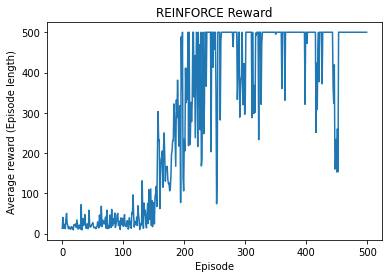

In [0]:
plt.title('REINFORCE Reward')
plt.xlabel('Episode')
plt.ylabel('Average reward (Episode length)')
plt.plot(agent.total_rewards)
plt.show()

Save the model

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
PATH=F"/content/gdrive/My Drive/" 
agent.model.save(PATH+'REINFORCE.h5')